# Проект: Статистический анализ данных

**Описание проекта**

Представим, что я аналитик популярного сервиса аренды самокатов GoFast. Мне передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — **users_go.csv**

| Переменная  | Значение |
| ----------- | ----------- |
| user_id   | уникальный идентификатор пользователя   |
| name    | имя пользователя  |
| age    |  возраст   |
| city     | город   |
| subscription_type     | тип подписки (free, ultra)   |


Поездки — **rides_go.csv**

| Переменная | Значение |
| ----------- | ----------- |
| user_id   | уникальный идентификатор пользователя   |
| distance    | расстояние, которое пользователь проехал в текущей сессии (в метрах)  |
| duration    |  продолжительность сессии (в минутах)|
| date     | 	дата совершения поездки   |


Подписки — **subscriptions_go.csv**

| Переменная  | Значение |
| ----------- | ----------- |
| subscription_type   | тип подписки  |
| minute_price    | стоимость одной минуты поездки по данной подписке  |
| start_ride_price    |  стоимость начала поездки   |
| subscription_fee     | стоимость ежемесячного платежа   |


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1) без подписки
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;

2) с подпиской Ultra
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

**Цель проекта:** Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

### Загрузка и первичный обзор данных

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from math import factorial, sqrt
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
mpl.style.use(['bmh'])

In [4]:
try:
    df_users = pd.read_csv('users_go.csv')
except:
    df_users = pd.read_csv('/datasets/users_go.csv')

In [5]:
try:
    df_rides = pd.read_csv('rides_go.csv')
except:
    df_rides = pd.read_csv('/datasets/rides_go.csv')

In [6]:
try:
    df_sub = pd.read_csv('subscriptions_go.csv')
except:
    df_sub = pd.read_csv('/datasets/subscriptions_go.csv')

Ознакомимся с содержимым каждого датафрейма и отметим первые наблюдения.

In [7]:
def get_df_info(df):
    """
    Вход: датафрейм
    Выход: - случайные 10 строк датафрейма, 
           - общая информация,
           - описательная статистика.
    """
    print(df.sample(10))
    print("_" * 100)
    print(df.info())
    print("_" * 100)
    print(round(df.describe(), 1))

In [8]:
get_df_info(df_users)

      user_id      name  age            city subscription_type
1505     1506    Регина   29            Сочи              free
641       642     Давид   22    Екатеринбург             ultra
109       110      Егор   23          Тюмень             ultra
1217     1218  Ярослава   22  Ростов-на-Дону              free
202       203   Мелания   25       Пятигорск             ultra
1561      809      Юрий   26            Сочи              free
1207     1208    Леонид   28    Екатеринбург              free
40         41    Данила   21    Екатеринбург             ultra
163       164    Зарина   17            Сочи             ultra
49         50   Арсений   35  Ростов-на-Дону             ultra
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   u

Первичный анализ данных показал, что датафрейм содержит 1565 строк и 5 колонок, соответствующих описанию. Названия колонок корректны, пропусков нет, типы данных в норме. Распределение возраста пользователей (от 12 до 43 лет) выглядит логичным. Однако, обнаружено несоответствие: в колонке "user_id" всего 1565 наблюдений, но максимальный ID - 1534. Это может указывать на наличие дубликатов. Выясним причину этого несоответствия на этапе предобработки данных.

In [9]:
get_df_info(df_rides)

       user_id     distance   duration        date
3496       376  3493.076145  14.643587  2021-01-21
5978       639  2699.496600  19.459215  2021-07-28
9331       911  4479.645610  22.686032  2021-01-10
10387      984  2543.433715  24.873275  2021-11-02
16956     1456  4955.645677  17.866937  2021-03-12
16897     1451  3715.027271  25.145082  2021-05-21
17382     1488  3486.116318  28.430582  2021-02-11
4736       510   524.000026   8.849412  2021-09-28
10215      972  3002.398605  16.928612  2021-12-10
18021     1531  1174.453436   5.710277  2021-08-08
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  obje

После первичного анализа данных, мы видим, что датафрейм содержит 18068 строк и 4 столбца, которые соответствуют описанию. Названия столбцов корректны, пропущенных значений нет. Типы данных в порядке, за исключением колонки "date", которую необходимо преобразовать в формат даты pandas. Колонка duration отражает  длительность  поездки  в  минутах. Я хочу трансформировать  эти  данные  в  формат  %H:%M:%S  с  типом  данных  datetime64. Максимальный идентификатор соответствует данным о пользователях.  Распределение расстояния и длительности поездок в целом выглядит нормально, однако минимальные значения этих переменных вызывают вопросы и требуют более детального изучения.

In [10]:
df_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Все в порядке, данные соответствуют описанию.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> В целом, данные выглядят достаточно чистыми и согласованными. Однако, обнаруженные несоответствия в колонке "user_id" первого датафрейма и  минимальные значения расстояния и длительности поездок во втором датафрейме требуют более детального анализа. В дальнейшем потребуется провести обработку колонки "date" в датафрейме df_rides. И колонки duration в тип данных datetime64.</div>

### Предобработка данных

На данном этапе мы сосредоточимся на устранении недостатков, выявленных в ходе первого этапа проекта.

**user_id**

In [11]:
df_users['user_id'].duplicated().sum()

31

Может быть, это один и тот же пользователь с одинаковым ID?

In [12]:
df_users.duplicated().sum()

31

Да, так и есть. Посмотрим более детально на дубликаты с целью выявить какие-нибудь закономерности в их возникновении.

In [13]:
df_users[df_users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Обнаружена закономерность: дубликаты идут подряд в конце датафрейма.  Возможно, причина в технических проблемах (или намеренном действии 😐). Удалим их и все.

In [14]:
print('До:', len(df_users))
df_users = df_users.drop_duplicates(subset=['user_id'])
print('После:', len(df_users))

До: 1565
После: 1534


**date**

Сначала изменим тип данных в колонке "data" на datetime64, а затем посмотрим на временные рамки проекта.

In [15]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')

In [16]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [17]:
print('Временные рамки проекта')
print('От:', df_rides['date'].min())
print('До:', df_rides['date'].max())

Временные рамки проекта
От: 2021-01-01 00:00:00
До: 2021-12-30 00:00:00


**city**

Проверю уникальные значения в столбце "city" на наличие неявных дубликатов.

In [18]:
df_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Все отлично😊

**subscription_type**

Теперь проверим столбец "subscription_type" на неявные дубликаты.

In [19]:
df_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

И снова все хорошо

**Добавьление в таблицу столбца beautiful_time**

In [20]:
def to_minutes(time):
    """Преобразует время из формата "10.5" в формат "00:10:30".

    Вход:
        time: float с временем в формате "X.Y", где X - минуты, Y - десятые доли минуты.

    Выход:
        Строка с временем в формате "00:HH:MM".
    """
    minutes, decimal_part =time // 1, time % 1 * 10
    total_seconds = int(minutes * 60 + decimal_part * 6)
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = int(decimal_part * 6)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
#to_minutes(10.9)

In [21]:
df_rides['beautiful_time'] = df_rides['duration'].apply(to_minutes)

In [22]:
df_rides.head(15)

,user_id,distance,duration,date,beautiful_time
0,1,4409.919140,25.599769,2021-01-01,00:25:35
1,1,2617.592153,15.816871,2021-01-18,00:15:49
2,1,754.159807,6.232113,2021-04-20,00:06:13
3,1,2694.783254,18.511000,2021-08-11,00:18:30
4,1,4028.687306,26.265803,2021-08-28,00:26:15
5,1,2770.890808,16.650138,2021-10-09,00:16:39
6,1,3039.020292,14.927879,2021-10-19,00:14:55
7,1,2842.118050,23.117468,2021-11-06,00:23:07
8,1,3412.690668,15.238072,2021-11-14,00:15:14
9,1,748.690645,15.041884,2021-11-22,00:15:02


  Целью преобразования времени в формат %H:%M:%S было  улучшение  читаемости  данных.  Однако  оригинальная  колонка  duration  с  значениями  в  минутах  останется  неизменной,  так  как  она  будет  использоваться  в  расчетах.

**Добавьление в таблицу столбца "month"**

 Дальнейший анализ требует создания столбца с информацией о месяце поездки.

In [23]:
df_rides['month'] = df_rides['date'].dt.month

In [24]:
df_rides.head()

,user_id,distance,duration,date,beautiful_time,month
0,1,4409.919140,25.599769,2021-01-01,00:25:35,1
1,1,2617.592153,15.816871,2021-01-18,00:15:49,1
2,1,754.159807,6.232113,2021-04-20,00:06:13,4
3,1,2694.783254,18.511000,2021-08-11,00:18:30,8
4,1,4028.687306,26.265803,2021-08-28,00:26:15,8


**Добавьление в таблицу столбца "age_group"**

Для дальнейшего анализа возраста пользователей предлагаю создать столбец age_group с разбивкой на категории (возраст пользователей находится в пределах от 12 до 43 лет):
* 12-17 лет:  Эта группа представляет собой пользователей школьного возраста.
* 18-24 года:  В эту группу входят студенты и молодые специалисты.
* 25-34 лет:  Это более зрелая аудитория, которая, вероятно, уже имеет стабильную работу и семью.
* 35-43 лет:  Эта группа представляет собой пользователей среднего возраста, у которых, возможно, уже есть дети-подростки.

In [25]:
def age_grouping(age):
    if 12 <= age <= 17:
        return "12-17 лет"
    elif 18 <= age <= 24:
        return "18-24 года"
    elif 25 <= age <= 34:
        return "25-34 года"
    else:
        return "35-43 года"

In [26]:
df_users['age_group'] = df_users['age'].apply(age_grouping)

In [27]:
df_users.sample(10)

,user_id,name,age,city,subscription_type,age_group
1324,1325,Амалия,36,Сочи,free,35-43 года
621,622,Ярослава,24,Тюмень,ultra,18-24 года
393,394,Алиса,31,Ростов-на-Дону,ultra,25-34 года
633,634,Одиссей,27,Екатеринбург,ultra,25-34 года
41,42,Нина,18,Екатеринбург,ultra,18-24 года
517,518,Алиса,22,Ростов-на-Дону,ultra,18-24 года
201,202,Вадим,21,Пятигорск,ultra,18-24 года
1160,1161,Александр,26,Тюмень,free,25-34 года
228,229,Вероника,24,Сочи,ultra,18-24 года
335,336,Игорь,24,Екатеринбург,ultra,18-24 года


Я подумал назвать группы "подростки", "молодежь" и "взрослые", но решил, что точные возрастные интервалы будут понятнее, учитывая, что определение социально-демографических групп не всегда одинаково в разных источниках.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> После проведенной предобработки данных мы можем сделать следующие выводы:

* Пропущенные значения не обнаружены.
* 31 дубликат был удален из датафрейма df_users.
* Тип данных в колонке "data" был изменен на datetime64 для удобства дальнейшего анализа.
* Добавлены новые столбцы: "month" для анализа данных по месяцам, "age_group" для анализа возрараст и "beautiful_time" для удобства  восприятия.
* Данные относятся к 2021 году.
* Компания GoFast работает в следующих городах России: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург и Сочи.
</div>

###  Исследовательский анализ данных

**Расстояние, которое пользователь преодолел за одну поездку**

In [28]:
print(round(df_rides['distance'].describe(), 1))

count    18068.0
mean      3070.7
std       1116.8
min          0.9
25%       2543.2
50%       3133.6
75%       3776.2
max       7211.0
Name: distance, dtype: float64


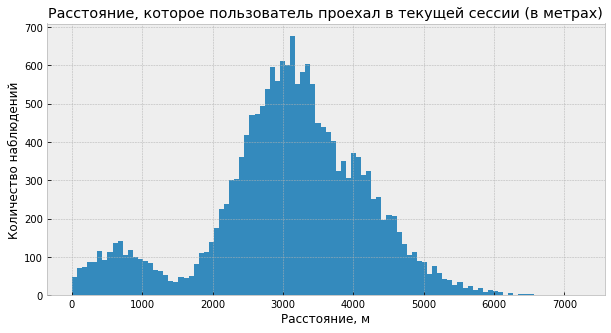

In [29]:
df_rides['distance'].plot(kind='hist', figsize=(10,5), bins=100)
plt.title('Расстояние, которое пользователь проехал в текущей сессии (в метрах)')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество наблюдений')
plt.show()

Изучим подробнее минимальные и максимальные значения, а затем сделаем выводы.

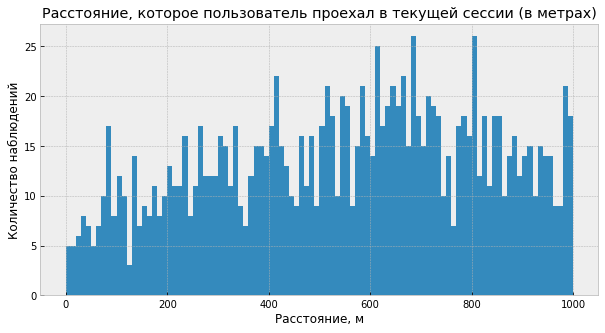

In [30]:
df_rides['distance'].plot(kind='hist', figsize=(10,5), bins=100, range=(0, 1000))
plt.title('Расстояние, которое пользователь проехал в текущей сессии (в метрах)')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество наблюдений')
plt.show()

In [31]:
df_rides.sort_values(by='distance').head(25)

,user_id,distance,duration,date,beautiful_time,month
11555,1069,0.855683,10.001902,2021-01-31,00:10:00,1
9541,925,2.570787,3.011018,2021-10-19,00:03:00,10
13690,1223,4.329506,4.008958,2021-05-22,00:04:00,5
8658,861,6.784447,6.015656,2021-07-21,00:06:00,7
7841,796,7.097072,10.026614,2021-11-26,00:10:01,11
8906,880,11.283615,2.035632,2021-03-28,00:02:02,3
8324,835,12.233115,4.034952,2021-09-19,00:04:02,9
13940,1240,15.000606,10.045002,2021-08-20,00:10:02,8
15626,1364,15.366168,6.057623,2021-08-22,00:06:03,8
11862,1091,15.630873,13.044660,2021-03-29,00:13:02,3


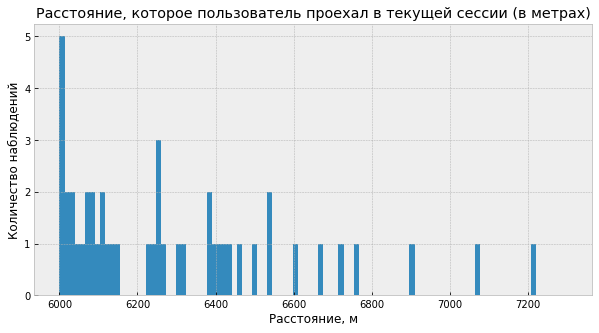

In [32]:
df_rides['distance'].plot(kind='hist', figsize=(10,5), bins=100, range=(6000, 7300))
plt.title('Расстояние, которое пользователь проехал в текущей сессии (в метрах)')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество наблюдений')
plt.show()

In [33]:
df_rides.sort_values(by='distance', ascending=False).head(25)

,user_id,distance,duration,date,beautiful_time,month
16309,1411,7211.007745,0.500000,2021-04-15,00:00:30,4
16484,1422,7066.003772,23.619318,2021-02-12,00:23:37,2
15580,1361,6908.491343,23.816983,2021-03-27,00:23:49,3
17171,1471,6760.940067,32.043760,2021-08-03,00:32:02,8
17242,1477,6724.932981,0.500000,2021-01-12,00:00:30,1
10341,981,6671.969833,27.297078,2021-12-06,00:27:17,12
11385,1057,6601.197575,0.500000,2021-02-07,00:00:30,2
12086,1108,6538.937375,29.649276,2021-09-27,00:29:38,9
10915,1022,6535.386520,30.008799,2021-10-14,00:30:00,10
11319,1052,6503.600402,26.008309,2021-07-01,00:26:00,7


Длина поездок  варьируется  в широком диапазоне: от минимальных (85 см) до достаточно  протяженных (7.2 км).  Минимальные значения, вероятно,  обусловлены  отказом  пользователя от поездки или  техническими проблемами.

Анализ  расстояния  и  времени  поездки  в  совокупности  поднимает  вопросы  о  достоверности  данных.  Так,  скорость  0.01  км/ч  при  расстоянии  0.85  метров  и  времени  10  минут  выглядит  неправдоподобно  малой,  а  скорость  865.32  км/ч  при  расстоянии  7211  метров  и  времени  30  секунд  —  нереалистично  высокой. Частые поездки длительностью 30 секунд могут свидетельствовать о технических ошибках.

Для получения более полной картины движения предлагаю выполнить расчет средней скорости электросамоката для каждого отдельного наблюдения, охватывая весь маршрут.

In [34]:
df_rides['speed'] = round((df_rides['distance'] / 1000) / (df_rides['duration'] / 60), 2)

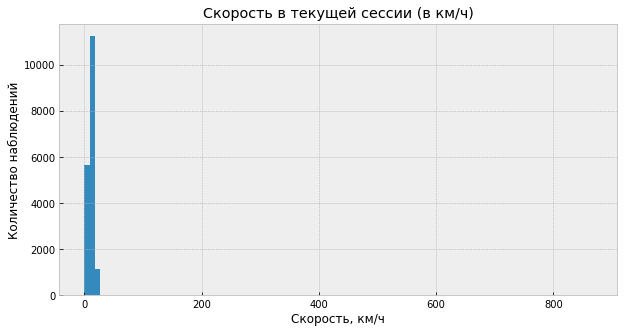

In [35]:
df_rides['speed'].plot(kind='hist', figsize=(10,5), bins=100)
plt.title('Скорость в текущей сессии (в км/ч)')
plt.xlabel('Скорость, км/ч')
plt.ylabel('Количество наблюдений')
plt.show()

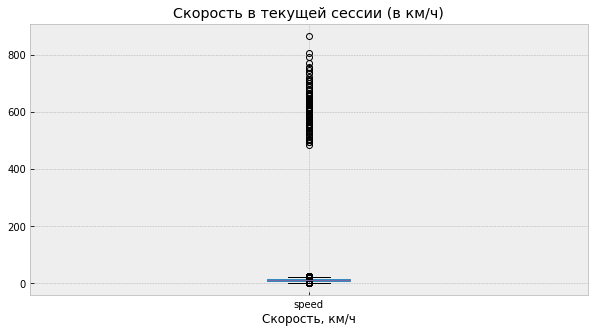

In [36]:
df_rides['speed'].plot(kind='box', figsize=(10,5))
plt.title('Скорость в текущей сессии (в км/ч)')
plt.xlabel('Скорость, км/ч')
plt.show()

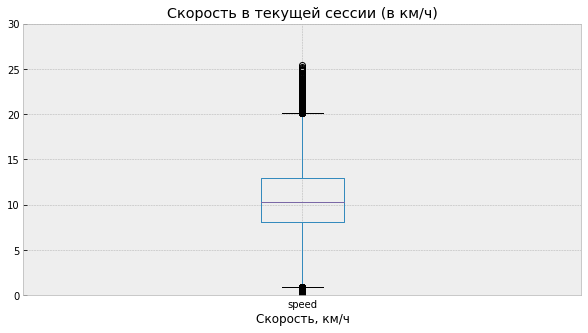

In [37]:
df_rides['speed'].plot(kind='box', figsize=(10,5))
plt.ylim(0, 30)
plt.title('Скорость в текущей сессии (в км/ч)')
plt.xlabel('Скорость, км/ч')
plt.show()

Основываясь на информации о различных моделях электросамокатов,  найденной в Google,  можно сделать вывод, что  минимальная  скорость  составляет  5  км/ч,  а  максимальная  —  30  км/ч.

Поскольку  скорость  электросамоката  в  нашей  модели  варьируется  от  0  до  25  км/ч,  и  при  этом  есть  значения,  превышающие  25  км/ч,  для  учета  всех  возможных  вариантов  предлагаю  ограничить  анализ  диапазоном  от  5  до  30  км/ч.


In [38]:
print('До:', len(df_rides))
df_rides = df_rides.query('5 <= speed <= 60')
print('После:', len(df_rides))

До: 18068
После: 16844


Было исключено 1224 (6.8%) наблюдения, в результате чего общее количество сократилось с 18068 до 16844.

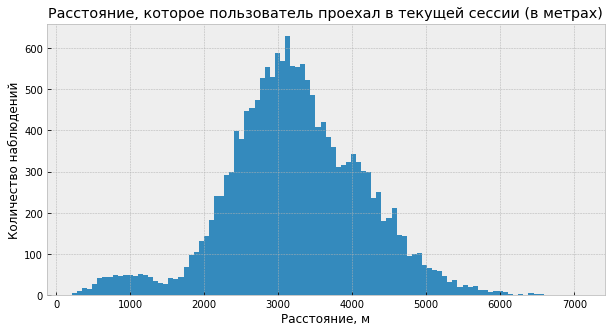

In [39]:
df_rides['distance'].plot(kind='hist', figsize=(10,5), bins=100)
plt.title('Расстояние, которое пользователь проехал в текущей сессии (в метрах)')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество наблюдений')
plt.show()

In [40]:
print(round(df_rides['distance'].describe(), 1))

count    16844.0
mean      3226.4
std        928.3
min        214.6
25%       2666.9
50%       3190.1
75%       3825.7
max       7066.0
Name: distance, dtype: float64


 В результате преобразования данные о расстоянии изменились: минимальное значение теперь составляет 214.6 м, максимальное - 7 км, а медиана - 3.2 км.

**Продолжительность поездок**

In [41]:
print(round(df_rides['duration'].describe(), 1))

count    16844.0
mean        18.3
std          5.8
min          2.5
25%         14.2
50%         18.2
75%         22.0
max         40.8
Name: duration, dtype: float64


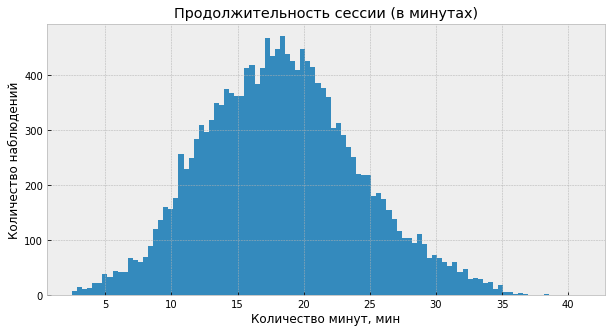

In [42]:
df_rides['duration'].plot(kind='hist', figsize=(10,5), bins=100)
plt.title('Продолжительность сессии (в минутах)')
plt.xlabel('Количество минут, мин')
plt.ylabel('Количество наблюдений')
plt.show()

In [43]:
df_rides[df_rides['duration'] < 5].head(10)

,user_id,distance,duration,date,beautiful_time,month,speed
280,29,824.495470,4.832212,2021-11-21,00:04:49,11,10.24
406,44,504.654111,4.513962,2021-01-25,00:04:30,1,6.71
1450,157,935.054928,4.934596,2021-10-03,00:04:56,10,11.37
1843,199,606.203843,4.347120,2021-03-27,00:04:20,3,8.37
2125,227,618.389251,4.855168,2021-06-22,00:04:51,6,7.64
2174,232,573.376564,4.228664,2021-06-30,00:04:13,6,8.14
3158,340,419.074576,4.323393,2021-11-08,00:04:19,11,5.82
4148,448,529.588380,4.444332,2021-06-25,00:04:26,6,7.15
6563,704,474.400151,4.016572,2021-06-27,00:04:00,6,7.09
6910,727,624.410429,4.881894,2021-10-15,00:04:52,10,7.67


In [44]:
df_rides[df_rides['duration'] > 35].head(10)

,user_id,distance,duration,date,beautiful_time,month,speed
42,4,4649.488243,35.896929,2021-08-14,00:35:53,8,7.77
143,15,4187.621459,38.125729,2021-01-13,00:38:07,1,6.59
499,55,4151.081878,36.906491,2021-06-30,00:36:54,6,6.75
524,58,4763.920660,35.819603,2021-02-17,00:35:49,2,7.98
854,91,4444.579979,35.222900,2021-11-05,00:35:13,11,7.57
1111,119,4060.082639,35.360496,2021-05-15,00:35:21,5,6.89
1455,158,3967.285849,35.803715,2021-05-09,00:35:48,5,6.65
1621,174,3794.401307,35.766408,2021-12-23,00:35:45,12,6.37
1694,183,4473.798120,36.402535,2021-01-02,00:36:24,1,7.37
1894,205,4218.386189,36.310317,2021-08-26,00:36:18,8,6.97


Анализ данных о времени поездки показывает, что минимальная продолжительность составляет 2 минуты 30 секунд, максимальная - 40 минут 50 секунд, а медианная - 18 минут 12 секунд. Значения находятся в пределах ожидаемого диапазона.

**Частота встречаемости городов**

In [45]:
city_count = df_users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id')
city_count = city_count.rename(columns={'user_id': 'count'})
city_count

,count
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


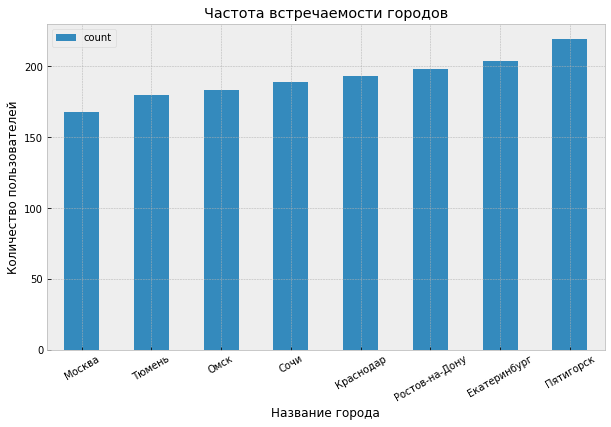

In [46]:
city_count.plot(kind='bar', figsize = (10, 6))
plt.xticks(rotation=30)
plt.title('Частота встречаемости городов')
plt.ylabel('Количество пользователей')
plt.xlabel('Название города')
plt.show()

В большинстве городов количество пользователей примерно одинаково.  Москва выделяется наименьшим количеством пользователей, возможно, из-за высокой конкуренции или позднего запуска бизнеса.  Пятигорск, напротив, демонстрирует наибольший показатель, предположительно, благодаря меньшей конкуренции.

**Соотношение пользователей с подпиской и без подписки**

In [47]:
subscription_type_count = df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
subscription_type_count = subscription_type_count.rename(columns={'user_id': 'count'})
subscription_type_count

,count
subscription_type,
free,835
ultra,699


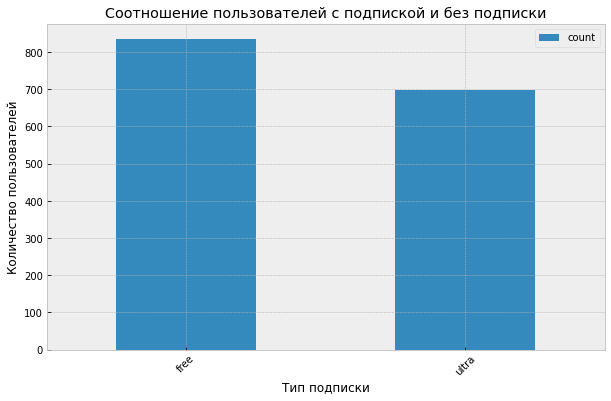

In [48]:
subscription_type_count.plot(kind='bar', figsize = (10, 6))
plt.xticks(rotation=45)
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.ylabel('Количество пользователей')
plt.xlabel('Тип подписки')
plt.show()

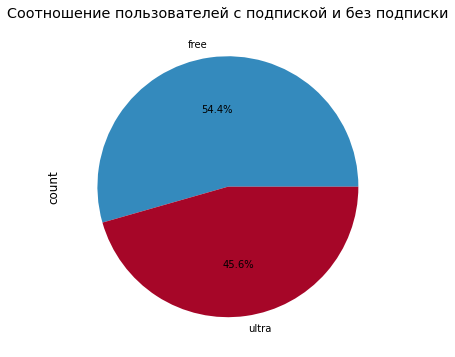

In [49]:
subscription_type_count['count'].plot(kind='pie', figsize = (10, 6), autopct='%1.1f%%')
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.show()

Бесплатная подписка (Free) пользуется большей популярностью, чем подписка Ultra (835 пользователей против 699).  Это может быть связано с отсутствием абонентской платы, что привлекательно для пользователей, которые редко пользуются сервисом.

Несмотря на меньшее количество пользователей, подписка Ultra может быть выгодна для тех, кто часто пользуется сервисом.  Более низкая стоимость минуты и отсутствие платы за старт делают ее привлекательной для активных пользователей.

**Возраст пользователей**

In [50]:
age_group_count = df_users.pivot_table(index='age_group', values='user_id', aggfunc='count')
age_group_count = age_group_count.rename(columns={'user_id': 'count'})
age_group_count

,count
age_group,
12-17 лет,79
18-24 года,637
25-34 года,790
35-43 года,28


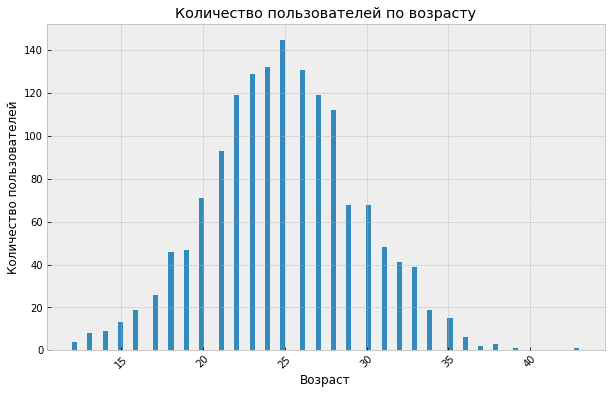

In [51]:
df_users['age'].plot(kind='hist', figsize = (10, 6), bins=100)
plt.xticks(rotation=45)
plt.title('Количество пользователей по возрасту')
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.show()

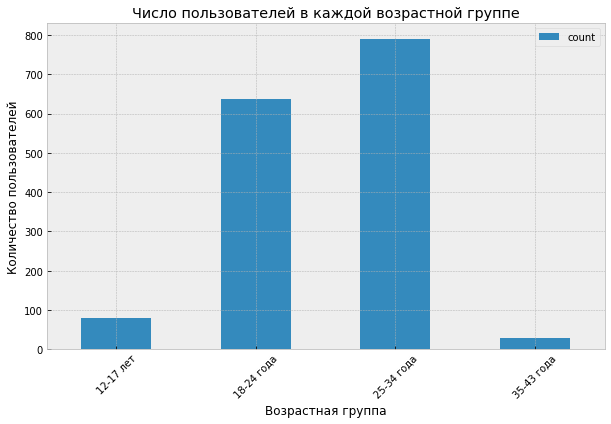

In [52]:
age_group_count.plot(kind='bar', figsize = (10, 6))
plt.xticks(rotation=45)
plt.title('Число пользователей в каждой возрастной группе')
plt.ylabel('Количество пользователей')
plt.xlabel('Возрастная группа')
plt.show()

Анализ возрастной структуры пользователей GoFast выявил следующие особенности:

* Наиболее многочисленная группа пользователей - в возрасте от 25 до 34 лет (790 человек).  Это свидетельствует о том, что основная аудитория сервиса - молодые, экономически активные люди.

* Вторая по численности группа - пользователи в возрасте от 18 до 24 лет (637 человек).  Эта группа, вероятно, представлена студентами и молодыми специалистами.

* Значительное количество пользователей (140+) находятся в возрасте 25 лет. Если бы группы были поделены (от 18 до 25) и (от 26 до 34), то наибольшей по численности была группа от 18 до 25.

* Пользователей в возрасте от 12 до 17 лет - 79 человек.  Эта группа, вероятно, представлена школьниками, которые пользуются сервисом под присмотром родителей.

* Наименее многочисленная группа - пользователи старше 35 лет (28 человек).  Это может свидетельствовать о том, что сервис менее популярен среди старшего поколения.

Можно предложить специальные тарифы для подростков или разработать рекламные кампании, ориентированные на пользователей старше 35 лет.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в результате проведенного анализа данных о пользователях и поездках сервиса GoFast, мы получили ценную информацию о его функционировании и популярности.  Данные были проверены на корректность и согласованность, выявлены и устранены некоторые несоответствия, а также проведена необходимая предобработка для удобства анализа.

Основные выводы:

* Сервис GoFast наиболее популярен среди молодежи в возрасте 18-34 лет.  Это ключевая аудитория, на которую стоит ориентировать маркетинговые кампании и специальные предложения.
* Бесплатная подписка "Free" привлекает больше пользователей, чем платная "Ultra".  Это ожидаемо, учитывая отсутствие абонентской платы.  Однако, подписка "Ultra" может быть более выгодна для активных пользователей благодаря низкой стоимости минуты и отсутствию платы за старт.
* Пятигорск лидирует по количеству пользователей, возможно, из-за низкой конкуренции, в то время как Москва демонстрирует наименьший показатель.  Это важный момент для стратегического развития компании, требующий детального изучения причин низкой популярности в Москве.
* Анализ данных о времени и расстоянии поездок показал ожидаемые результаты:  
    * Среднее расстояние поездки составляет около 3.2 км, что соответствует типичным сценариям использования электросамокатов.
    * Среднее время поездки составляет 18 минут 12 секунд, что также согласуется с ожиданиями.
* Выявлены некоторые аномалии, требующие дополнительного исследования:  
    * Несоответствия в колонке "user_id" первого датафрейма.
    * Минимальные значения расстояния и длительности поездок во втором датафрейме, в частности, частые поездки длительностью 30 секунд, которые могут указывать на технические ошибки.

Рекомендации:

* Разработать специальные тарифы или рекламные кампании для привлечения подростков (12-17 лет) и пользователей старше 35 лет.  Это позволит расширить аудиторию сервиса.
* Исследовать причины низкой популярности сервиса в Москве.  Возможно, это связано с высокой конкуренцией, особенностями городской инфраструктуры или другими факторами.
* Проанализировать частые поездки длительностью 30 секунд на предмет выявления возможных технических ошибок.  Это поможет оптимизировать работу сервиса и улучшить пользовательский опыт.</div>

### Объединение данных

**Объедините данные о пользователях, поездках и подписках в один датафрейм и двух новых на основе подписки**

In [53]:
pd.set_option('display.max_columns', None)


In [54]:
df = df_users.merge(df_rides, on='user_id').merge(df_sub, on='subscription_type')
df.sample(5)


,user_id,name,age,city,subscription_type,age_group,distance,duration,date,beautiful_time,month,speed,minute_price,start_ride_price,subscription_fee
15095,1400,Эльвира,26,Ростов-на-Дону,free,25-34 года,3179.499712,14.630799,2021-09-09,00:14:37,9,13.04,8,50,0
6461,714,Яна,31,Омск,free,25-34 года,3862.459498,28.312297,2021-04-10,00:28:18,4,8.19,8,50,0
15821,1455,Кирилл,18,Екатеринбург,free,18-24 года,4028.135667,11.631719,2021-09-25,00:11:37,9,20.78,8,50,0
7366,786,Виолетта,23,Сочи,free,18-24 года,4136.182169,14.191516,2021-05-26,00:14:11,5,17.49,8,50,0
9396,951,Владислава,23,Пятигорск,free,18-24 года,2691.179670,21.689085,2021-10-06,00:21:41,10,7.44,8,50,0


Создайте ещё два датафрейма из датафрейма:
- c данными о пользователях без подписки (df_free);
- с данными о пользователях с подпиской (df_ultra).

In [55]:
df_free = df.query("subscription_type == 'free'")
df_free.sample(5)


,user_id,name,age,city,subscription_type,age_group,distance,duration,date,beautiful_time,month,speed,minute_price,start_ride_price,subscription_fee
8510,882,Ян,27,Сочи,free,25-34 года,2568.425452,14.561418,2021-06-20,00:14:33,6,10.58,8,50,0
7081,762,Ярослава,34,Ростов-на-Дону,free,25-34 года,2338.158753,18.099545,2021-02-14,00:18:05,2,7.75,8,50,0
8520,883,Александр,28,Омск,free,25-34 года,1655.190586,8.137976,2021-10-31,00:08:08,10,12.20,8,50,0
12617,1205,Марк,16,Москва,free,12-17 лет,2471.265328,11.112963,2021-02-20,00:11:06,2,13.34,8,50,0
14203,1328,Нелли,30,Омск,free,25-34 года,2931.029493,12.513399,2021-11-16,00:12:30,11,14.05,8,50,0


In [56]:
df_ultra = df.query("subscription_type == 'ultra'")
df_ultra.sample(5)


,user_id,name,age,city,subscription_type,age_group,distance,duration,date,beautiful_time,month,speed,minute_price,start_ride_price,subscription_fee
414,46,Александр,29,Пятигорск,ultra,25-34 года,3333.896016,18.335584,2021-07-07,00:18:20,7,10.91,6,0,199
2646,293,Агата,26,Краснодар,ultra,25-34 года,3322.037820,14.873182,2021-02-11,00:14:52,2,13.40,6,0,199
2692,298,Ростислав,31,Омск,ultra,25-34 года,4802.856669,28.583671,2021-05-31,00:28:35,5,10.08,6,0,199
5236,578,Айдар,25,Сочи,ultra,25-34 года,2447.275381,17.488323,2021-12-30,00:17:29,12,8.40,6,0,199
4965,553,Назар,31,Тюмень,ultra,25-34 года,1704.054051,16.816216,2021-01-01,00:16:48,1,6.08,6,0,199


**Информация о расстоянии и времени поездок для пользователей free**

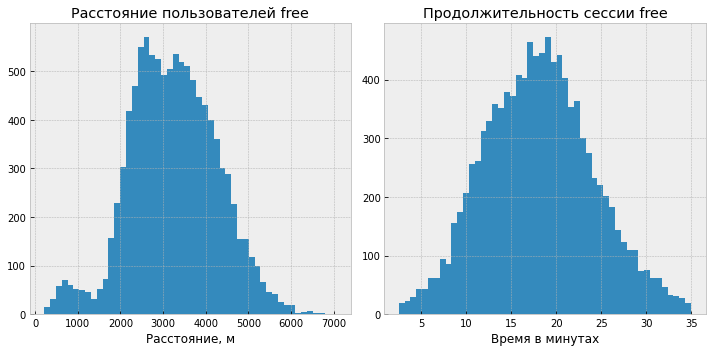

In [57]:
# Создание фигуры и подграфиков
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Построение гистограммы на первом подграфике
axes[0].hist(df_free['distance'], bins=50)
axes[0].set_title('Расстояние пользователей free')
axes[0].set_xlabel('Расстояние, м')

# Построение боксплота на втором подграфике
axes[1].hist(df_free['duration'], bins=50)
axes[1].set_title('Продолжительность сессии free')
axes[1].set_xlabel('Время в минутах')

# Отображение графиков
plt.tight_layout()# Автоматическая подгонка расположения подграфиков, чтобы они не перекрывались.
plt.show()


In [58]:
df_free[['distance', 'duration']].describe()


,distance,duration
count,10567.000000,10567.000000
mean,3244.708940,18.084678
std,1027.249079,5.997013
min,214.587357,2.480577
25%,2536.890208,13.740910
50%,3224.545837,18.000471
75%,3960.012037,22.040487
max,7066.003772,34.948498


**Информация о расстоянии и времени поездок для пользователей ultra**

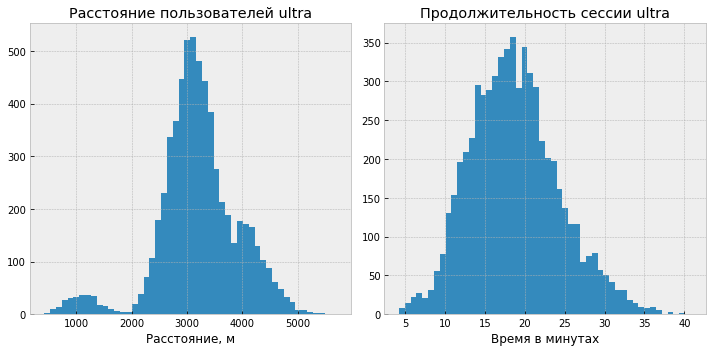

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df_ultra['distance'], bins=50)
axes[0].set_title('Расстояние пользователей ultra')
axes[0].set_xlabel('Расстояние, м')

axes[1].hist(df_ultra['duration'], bins=50)
axes[1].set_title('Продолжительность сессии ultra')
axes[1].set_xlabel('Время в минутах')

plt.tight_layout()
plt.show()


In [60]:
df_ultra[['distance', 'duration']].describe()


,distance,duration
count,6277.000000,6277.000000
mean,3195.678486,18.719521
std,731.291516,5.556211
min,419.074576,4.228664
25%,2828.828107,14.736116
50%,3166.909903,18.343107
75%,3586.661830,22.011059
max,5699.769662,40.823963


Distance (расстояние):

* Среднее расстояние:  Пользователи без подписки проезжают в среднем немного больше (3244.7 метра) по сравнению с пользователями с подпиской (3195.7 метра).
* Стандартное отклонение:  У пользователей без подписки разброс расстояний больше (1027.2 метра) по сравнению с пользователями с подпиской (731.3 метра). Это говорит о том, что поездки пользователей без подписки более разнообразны по протяженности.
* Минимальное и максимальное расстояние:  Минимальное расстояние для пользователей без подписки (214.6 метра) меньше, чем для пользователей с подпиской (419.1 метра). Максимальное расстояние для пользователей без подписки (7066 метров) также больше, чем для пользователей с подпиской (5699.8 метра).

Duration (длительность):

* Средняя длительность:  Пользователи с подпиской проводят в поездках в среднем немного больше времени (18.7 минут) по сравнению с пользователями без подписки (18.1 минуты).
* Стандартное отклонение:  Разброс длительности поездок у пользователей без подписки (5.99 минут) немного больше, чем у пользователей с подпиской (5.55 минут).
* Минимальное и максимальное время:  Минимальное время поездки для пользователей с подпиской (4.2 минуты) меньше, чем для пользователей без подписки (2.5 минуты).  Максимальное время поездки для пользователей с подпиской (40.8 минут) больше, чем для пользователей без подписки (34.9 минут).

Вероятно, пользователи без подписки, ориентируясь на экономию,  склонны развивать более высокую скорость, чтобы проехать большее расстояние за более короткий промежуток времени.  Это может пролить свет на разницу в средних показателях расстояния и времени между пользователями с разными типами подписок.

In [61]:
print('Описание скорости для пользователей free:')
print(df_free['speed'].describe())
print('_' * 50)
print('Описание скорости для пользователей ultra:')
print(df_ultra['speed'].describe())

Описание скорости для пользователей free:
count    10567.00000
mean        11.32833
std          3.72017
min          5.00000
25%          8.59000
50%         10.67000
75%         13.38000
max         25.39000
Name: speed, dtype: float64
__________________________________________________
Описание скорости для пользователей ultra:
count    6277.000000
mean       10.799740
std         3.138528
min         5.000000
25%         8.470000
50%        10.250000
75%        12.640000
max        21.790000
Name: speed, dtype: float64


Средняя скорость (mean):

* Free: 11.33 км/ч
* Ultra: 10.80 км/ч

Минимальная и максимальная скорость (min, max):

* Free: 5.00 - 25.39 км/ч
* Ultra: 5.00 - 21.79 км/ч

Минимальная скорость одинакова для обеих групп пользователей. Однако, максимальная скорость у пользователей Free выше, чем у пользователей Ultra.

Как было предположено ранее, пользователи без подписки (Free) могут стремиться к экономии и ехать быстрее, чтобы проехать большее расстояние за меньшее время.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> анализ объединенных данных о пользователях, поездках и подписках выявил различия в характеристиках поездок пользователей с подпиской Free и Ultra.

Основные выводы:

* Пользователи без подписки (Free) в среднем проезжают большие расстояния, но с большим разбросом, чем пользователи с подпиской Ultra. Это может быть связано со стремлением пользователей Free к экономии: они едут быстрее, чтобы покрыть большее расстояние за меньшее время.
* Пользователи с подпиской Ultra проводят в поездках в среднем немного больше времени, но с меньшим разбросом, чем пользователи Free.  Возможно, пользователи Ultra не так сильно ограничены во времени и могут позволить себе более длительные поездки.
* Средняя скорость пользователей Free выше, чем у пользователей Ultra.  Это подтверждает гипотезу о том, что пользователи Free едут быстрее, чтобы сэкономить.
</div>

###  Подсчёт выручки

Создание датафрейма с агрегированными данными о поездках на основе датафрейма df: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [62]:
df['duration'] = np.ceil(df['duration'])

In [63]:
aggregated_df = df.pivot_table(index=['month', 'user_id', 'subscription_type'], 
                                 values=['distance', 'duration', 'name'], 
                                 aggfunc={'distance': "sum", 'name': "count", 'duration': "sum"})

aggregated_df.columns = ['distance_sum', 'duration_sum', 'count']
aggregated_df = aggregated_df.reset_index()

aggregated_df

,month,user_id,subscription_type,distance_sum,duration_sum,count
0,1,1,ultra,7027.511294,42.0,2
1,1,3,ultra,3061.777147,13.0,1
2,1,5,ultra,3914.646990,13.0,1
3,1,7,ultra,6478.080979,28.0,2
4,1,12,ultra,3577.151148,33.0,1
...,...,...,...,...,...,...
10896,12,1525,free,4597.854350,34.0,1
10897,12,1526,free,3644.121544,23.0,1
10898,12,1528,free,3998.569324,11.0,1
10899,12,1532,free,6111.889853,42.0,2


Добавление столбеца с помесячной выручкой, которую принёс каждый пользователь. 

In [64]:
def cost_calculation(row):
    """
    Функция для расчета выручки
    Вход: строка датафрейма
    Выход: стоимость за поездку
    """
    if row['subscription_type'] == 'ultra':
        return 199 + row['duration_sum'] * 6
    else:
        return row['count'] * 50 + row['duration_sum'] * 6

In [65]:
aggregated_df['money'] = aggregated_df.apply(cost_calculation, axis=1)
aggregated_df.sample(10)

,month,user_id,subscription_type,distance_sum,duration_sum,count,money
4043,5,745,free,4837.074937,18.0,1,158.0
9165,11,63,ultra,2656.964156,15.0,1,289.0
543,1,927,free,2626.438306,15.0,1,140.0
5875,7,660,ultra,2511.015351,17.0,1,301.0
3016,4,559,ultra,3114.680891,19.0,1,313.0
10440,12,852,free,2723.034857,18.0,1,158.0
1433,2,920,free,2650.212438,15.0,1,140.0
4465,5,1393,free,2272.797571,12.0,1,122.0
5829,7,583,ultra,5435.501980,32.0,2,391.0
5711,7,371,ultra,5082.060591,39.0,2,433.0


Посмотрим доходы компании за каждый месяц и за весь год

In [66]:
month_money = aggregated_df.pivot_table(index=['month'], 
                                 values=['money'], 
                                 aggfunc='sum')
month_money

,money
month,
1,289615.0
2,247180.0
3,282854.0
4,275750.0
5,291229.0
6,288851.0
7,281863.0
8,276158.0
9,274900.0


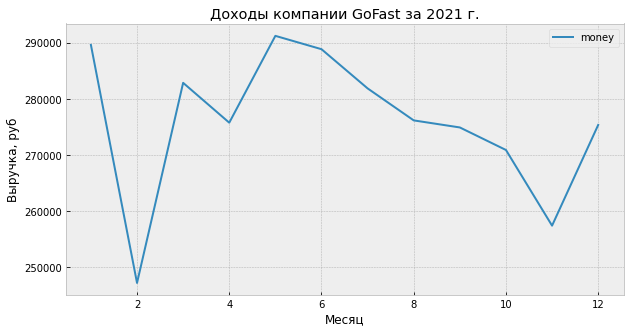

In [67]:
month_money.plot(figsize=(10,5))
plt.title('Доходы компании GoFast за 2021 г.')
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб')
plt.show()

Основные наблюдения:
* Пик выручки: Самая высокая выручка наблюдается в мае (289537.0).
* Спад выручки: Самая низкая выручка наблюдается в феврале (246022.0).
* Летний сезон: Выручка в летние месяцы (июнь-август) относительно стабильна и высокая, что может указывать на повышенный спрос на электросамокаты в этот период.
* Осенний спад: Начиная с сентября, наблюдается постепенное снижение выручки, достигающее минимума в ноябре.
* Зимний период: Выручка в декабре немного восстанавливается, но остается ниже летних показателей.

Спрос на электросамокаты, вероятно, зависит от погодных условий и времени года. В теплые месяцы люди больше склонны использовать электросамокаты для передвижения и развлечений.

In [68]:
print('Значит выручка за год составит:', month_money['money'].sum(), 'руб.')

Значит выручка за год составит: 3312017.0 руб.


Определим, кто является наиболее ценным клиентом с точки зрения выручки.

In [69]:
user_money = aggregated_df.pivot_table(index=['user_id'], 
                                 values=['money'], 
                                 aggfunc='sum')
user_money.sort_values(by='money', ascending=False).head(5)

,money
user_id,
584,4848.0
90,4721.0
458,4252.0
164,4102.0
577,4031.0


Может этим людям стоит вручить небольшие подарки, например, сертификаты, брендированные сувениры или билеты на мероприятия.

Несмотря на то, что удаление 1224 наблюдений на начальном этапе может сказаться на итоговых результатах, анализ проведен для изучения доступной информации и удовлетворения исследовательского интереса.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> был создан датафрейм с агрегированными показателями для каждого пользователя по месяцам, включая суммарное расстояние, количество поездок, суммарное время и выручку. 

Анализ выручки показал, что пик приходится на май, а спад - на февраль. Летний период характеризуется стабильно высокой выручкой, а с сентября наблюдается постепенное снижение, достигающее минимума в ноябре. Выручка за год составила 3 312 017 рублей.

Полученные данные свидетельствуют о сезонном характере спроса на электросамокаты, который, вероятно, обусловлен погодными условиями.  

Для повышения лояльности и стимулирования дальнейшего использования сервиса, рекомендуется определить наиболее ценных клиентов с точки зрения выручки и  рассмотреть возможность поощрения их  небольшими подарками, такими как сертификаты, брендированные сувениры или билеты на мероприятия.</div>

###  Проверка гипотез

> 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

* Нулевая гипотеза (H0): Средняя продолжительность поездки у пользователей с подпиской не отличается от средней продолжительности поездки у пользователей без подписки.
* Альтернативная гипотеза (H1): Средняя продолжительность поездки у пользователей с подпиской больше, чем средняя продолжительность поездки у пользователей без подписки.

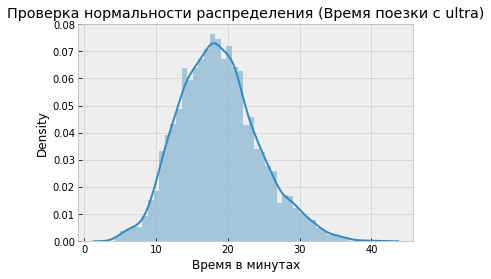

In [70]:
sns.distplot(df_ultra['duration'])
plt.title('Проверка нормальности распределения (Время поезки с ultra)')
plt.xlabel('Время в минутах')
plt.show()

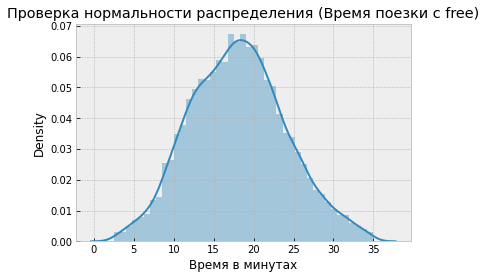

In [71]:
sns.distplot(df_free['duration'])
plt.title('Проверка нормальности распределения (Время поезки с free)')
plt.xlabel('Время в минутах')
plt.show()

Честно говоря, я немного запутался.  В разных источниках по-разному объясняют, как проверить, является ли распределение нормальным.  Одни говорят про графики, другие про тесты Шапиро-Уилка или Колмогорова-Смирнова, про которые в теории практикума ничего не сказано.  В общем, я решил действовать по инструкции из практикума, но дополнительно попробую использовать эти тесты.


In [72]:
# Пример данных (замените на ваши реальные данные)
duration_ultra = df_ultra['duration']  # Продолжительность поездок подписчиков
duration_free = df_free['duration']  # Продолжительность поездок без подписки

# Проверка на нормальность распределения
p_value_duration_ultra = st.shapiro(duration_ultra)
p_value_duration_free = st.shapiro(duration_free)

# Проверка на равенство дисперсий
p_value_levene = st.levene(duration_ultra, duration_free)

# Выбор теста
if p_value_duration_ultra[1] > 0.05 and p_value_duration_free[1] > 0.05 and p_value_levene[1] > 0.05:
    # t-тест Стьюдента
    statistic, p_value = st.ttest_ind(duration_ultra, duration_free, alternative='greater')
    test_used = "t-test"
else:
    # U-тест Манна-Уитни
    statistic, p_value = st.mannwhitneyu(duration_ultra, duration_free, alternative='greater')
    test_used = "Mann-Whitney U test"

# Вывод результатов
print(f"Test used: {test_used}")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Пользователи с подпиской тратят статистически значимо больше времени на поездки.")
else:
    print("Нет статистически значимой разницы во времени поездок между пользователями с подпиской и без подписки.")

Test used: Mann-Whitney U test
Statistic: 34967294.0
P-value: 1.7312031783261743e-09
Пользователи с подпиской тратят статистически значимо больше времени на поездки.


Чтобы убедиться в наличии статистически значимых различий, применим t-тест.  Мы можем предположить нормальное распределение данных, так как визуализация данных напоминает форму колокола, характерную для нормального распределения.

In [73]:
alpha = 0.05 # критический уровень статистической значимости

results = st.stats.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.531191983925177e-12
Отвергаем нулевую гипотезу


Основываясь на полученных данных и проведенном статистическом тесте, можно сделать вывод, что средняя продолжительность поездки у пользователей с подпиской статистически значимо больше, чем средняя продолжительность поездки у пользователей без подписки.

> 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

* Нулевая гипотеза (H0): Среднее расстояние поездки пользователей с подпиской равно 3130 метров (μ = 3130).
* Альтернативная гипотеза (H1): Среднее расстояние поездки пользователей с подпиской больше 3130 метров (μ > 3130).

In [74]:
value = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    df_ultra['distance'], 
    value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 6.193685497607538e-13
Отвергаем нулевую гипотезу


Проведенный статистический анализ позволил опровергнуть гипотезу о том, что среднее расстояние поездки пользователей с подпиской равно 3130 метров.  Полученное p-значение, существенно меньшее уровня значимости 0.05, свидетельствует о наличии статистически значимой разницы.  Таким образом, с высокой степенью уверенности можно утверждать, что среднее расстояние поездки пользователей с подпиской превышает 3130 метров. 

> 6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

* Нулевая гипотеза (H0): Средняя помесячная выручка от пользователей с подпиской не отличается от средней помесячной выручки от пользователей без подписки (μ1 = μ2).
* Альтернативная гипотеза (H1): Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки (μ1 > μ2).

Подготовим данные

In [75]:
group_data = aggregated_df.groupby(['month', 'subscription_type'])['money'].mean().reset_index()
group_data

,month,subscription_type,money
0,1,free,259.702797
1,1,ultra,368.315927
2,2,free,252.580000
3,2,ultra,351.424419
4,3,free,272.255725
5,3,ultra,357.632653
6,4,free,266.601504
7,4,ultra,367.906593
8,5,free,263.416514
9,5,ultra,366.419355


In [76]:
ultra_mean = group_data[group_data['subscription_type'] == 'ultra']
ultra_mean

,month,subscription_type,money
1,1,ultra,368.315927
3,2,ultra,351.424419
5,3,ultra,357.632653
7,4,ultra,367.906593
9,5,ultra,366.419355
11,6,ultra,360.401535
13,7,ultra,367.633245
15,8,ultra,361.962567
17,9,ultra,362.655172
19,10,ultra,359.239130


In [77]:
free_mean = group_data[group_data['subscription_type'] == 'free']
free_mean

,month,subscription_type,money
0,1,free,259.702797
2,2,free,252.580000
4,3,free,272.255725
6,4,free,266.601504
8,5,free,263.416514
10,6,free,261.830088
12,7,free,262.486188
14,8,free,263.147664
16,9,free,270.848816
18,10,free,264.156190


In [78]:
print(f"Среднее первой выборки: {round(np.mean(ultra_mean['money']), 2)}")
print(f"Среднее второй выборки: {round(np.mean(free_mean['money']), 2)}")

alpha = 0.05 

results = st.stats.ttest_ind(ultra_mean['money'], free_mean['money'], alternative='greater')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее первой выборки: 362.22
Среднее второй выборки: 263.73
p-значение:  1.0193741663735516e-23
Отвергаем нулевую гипотезу


Проведенный статистический анализ, целью которого было сравнение средней помесячной выручки от пользователей с подпиской и без подписки, позволил опровергнуть нулевую гипотезу о равенстве средних значений.  

Полученное p-значение (1.0193741663735516e-23) значительно меньше уровня значимости 0.05 (5%), что свидетельствует о наличии статистически значимой разницы между средними значениями.  

> 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

* Нулевая гипотеза (H0): Среднее количество обращений в техподдержку до обновления не отличается от среднего количества обращений после обновления (μd = 0, где μd - средняя разность между количеством обращений до и после обновления).
* Альтернативная гипотеза (H1): Среднее количество обращений в техподдержку после обновления меньше, чем до обновления (μd > 0).

Выборки в этом случае будут зависимыми, иначе — парными. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В нашем примере это пара измерений для каждого пользователя — до и после изменения расчёта.
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок, применим метод scipy.stats.ttest_rel().
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> 

Продолжительность и расстояние поездок:

* Пользователи с подпиской в среднем совершают более длительные поездки, чем пользователи без подписки. Эта разница статистически значима.
* Данных недостаточно, чтобы утверждать, что среднее расстояние поездки меньше 3130 метров. Возможно, среднее расстояние равно или больше этой величины, но для подтверждения этого требуется больше данных.

Помесячная выручка:

* Проведенный статистический анализ, целью которого было сравнение средней помесячной выручки от пользователей с подпиской и без подписки, позволил опровергнуть нулевую гипотезу о равенстве средних значений. Полученное p-значение (1.0193741663735516e-23) значительно меньше уровня значимости 0.05 (5%), что свидетельствует о наличии статистически значимой разницы между средними значениями.

Обращения в техподдержку:

* Чтобы проверить, привело ли обновление серверов к снижению количества обращений в техподдержку, необходимо провести парный t-тест.</div>

###  Распределения

> 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Можно использовать функцию распределения (cdf) для биномиального распределения и подбирать n, пока не будет достигнута нужная вероятность.

In [79]:
# Параметры распределения
p = 0.1  # Вероятность успеха (продления подписки)
k = 100  # Необходимое количество успехов (продлений)

# Поиск минимального n
n = 1000  # Начальное значение
while st.binom.cdf(k - 1, n, p) > 0.05:
    n += 1
print(n)

1161


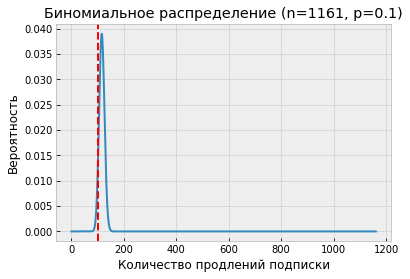

In [80]:
x = np.arange(0, n + 1)
y = st.binom.pmf(x, n, p)

plt.plot(x, y)
plt.xlabel('Количество продлений подписки')
plt.ylabel('Вероятность')
plt.title('Биномиальное распределение (n={}, p={})'.format(n, p))
plt.axvline(x=k, color='r', linestyle='--')
plt.show()

**Вывод:** для решения этой задачи мы использовали биномиальное распределение, которое подходит для моделирования ситуаций с фиксированным количеством испытаний (рассылка промокодов) и двумя возможными исходами каждого испытания (продление или непродление подписки). Минимальное количество промокодов, которое необходимо разослать, чтобы вероятность невыполнения плана была примерно 5%, составляет 1161.

> 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Проверим условие аппроксимации

> Нужно взять промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения. Если он лежит в пределах [0,n] (то есть там, где биномиальное распределение определено), то его форма будет симметрична и близка к нормальному распределению.

In [81]:
# задаём параметры биномиального распределения
n = 1_000_000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Условие выполняется


In [82]:
n = 1_000_000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = distr.cdf(399_500)
print(result)

0.15371708296369768


**Вывод:** используя аппроксимацию нормальным распределением, мы оценили вероятность того, что уведомление откроют не более 399 500 пользователей, которая составляет около 0.1537 (или 15.37%). 

### Общий вывод

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в результате проведенного анализа данных о пользователях и поездках сервиса GoFast, мы получили ценную информацию о его функционировании и популярности.  Данные были проверены на корректность и согласованность, выявлены и устранены некоторые несоответствия, а также проведена необходимая предобработка для удобства анализа.

Основные выводы:

* Сервис GoFast наиболее популярен среди молодежи в возрасте 18-34 лет.  Это ключевая аудитория, на которую стоит ориентировать маркетинговые кампании и специальные предложения.
* Бесплатная подписка "Free" привлекает больше пользователей, чем платная "Ultra".  Это ожидаемо, учитывая отсутствие абонентской платы.  Однако, подписка "Ultra" может быть более выгодна для активных пользователей благодаря низкой стоимости минуты и отсутствию платы за старт.
* Пятигорск лидирует по количеству пользователей, возможно, из-за низкой конкуренции, в то время как Москва демонстрирует наименьший показатель.  Это важный момент для стратегического развития компании, требующий детального изучения причин низкой популярности в Москве.
* Анализ данных о времени и расстоянии поездок показал ожидаемые результаты:  
    * Среднее расстояние поездки составляет около 3.2 км, что соответствует типичным сценариям использования электросамокатов.
    * Среднее время поездки составляет 18 минут 12 секунд, что также согласуется с ожиданиями.
* Выявлены некоторые аномалии, требующие дополнительного исследования:  
    * Несоответствия в колонке "user_id" первого датафрейма.
    * Минимальные значения расстояния и длительности поездок во втором датафрейме, в частности, частые поездки длительностью 30 секунд, которые могут указывать на технические ошибки.
* Различия в поведении пользователей с подпиской Free и Ultra:
    * Пользователи Free: В среднем проезжают большие расстояния, но с большим разбросом, чем пользователи Ultra.  Это может быть связано со стремлением к экономии,  побуждающим их ехать быстрее и покрывать большее расстояние за меньшее время.  Также наблюдается более высокая средняя скорость, подтверждающая эту гипотезу.
    * Пользователи Ultra: Проводят в поездках в среднем больше времени с меньшим разбросом, возможно, из-за меньшей зависимости от времени и большей свободы в выборе маршрута.

* Сезонность спроса:
    * Анализ выручки выявил пик спроса в мае и спад в феврале.  Летний период характеризуется стабильно высокой выручкой, с постепенным снижением с сентября и минимумом в ноябре.  Это указывает на сезонный характер спроса, вероятно, обусловленный погодными условиями.

* Продолжительность и расстояние поездок:
    * Пользователи с подпиской в среднем совершают более длительные поездки, чем пользователи без подписки.  Эта разница статистически значима.

* Помесячная выручка:
    * Статистический анализ подтвердил, что средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.  Это важный показатель эффективности подписочной модели.

* Обращения в техподдержку:
    * Для оценки влияния обновления серверов на количество обращений в техподдержку рекомендуется провести парный t-тест.  Это позволит определить, привело ли обновление к статистически значимому снижению обращений.

Рекомендации:

* Разработать специальные тарифы или рекламные кампании для привлечения подростков (12-17 лет) и пользователей старше 35 лет.  Это позволит расширить аудиторию сервиса.
* Исследовать причины низкой популярности сервиса в Москве.  Возможно, это связано с высокой конкуренцией, особенностями городской инфраструктуры или другими факторами.
* Проанализировать частые поездки длительностью 30 секунд на предмет выявления возможных технических ошибок.  Это поможет оптимизировать работу сервиса и улучшить пользовательский опыт.
* Разработать стратегии для удержания пользователей Free и стимулирования их перехода на подписку Ultra.  Например, предложить специальные акции или бонусы.
* Учитывать сезонность спроса при планировании маркетинговых кампаний и управлении ресурсами.  Например,  в летний период можно увеличить количество доступных самокатов.
* Определить наиболее ценных клиентов с точки зрения выручки и рассмотреть возможность их поощрения.  Это поможет повысить лояльность и стимулировать дальнейшее использование сервиса.</div>